## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [9]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp030'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 256 #224
    tile_size = 256 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [12]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [13]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [14]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [15]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [16]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [17]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [20]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [21]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [22]:
train_dataset[0][0].shape

torch.Size([6, 256, 256])

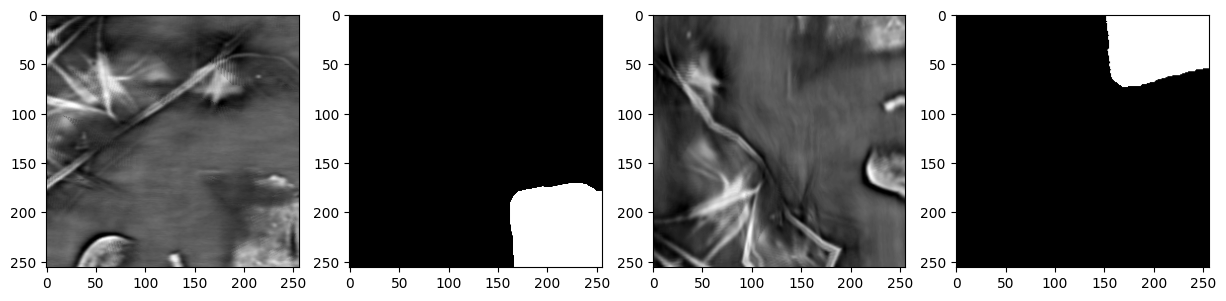

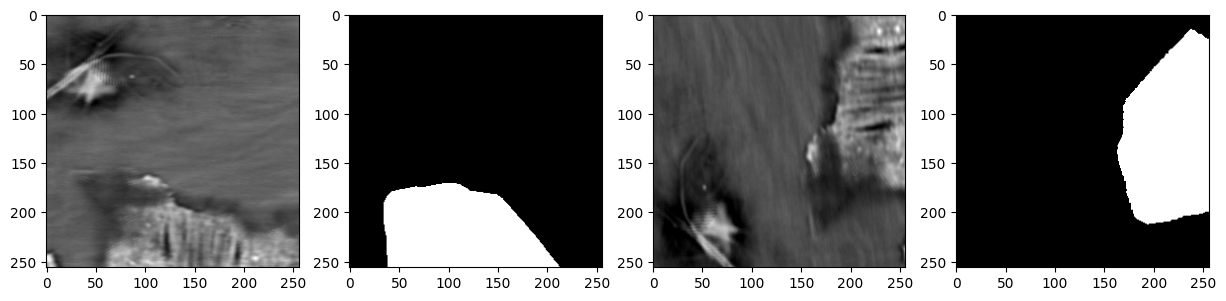

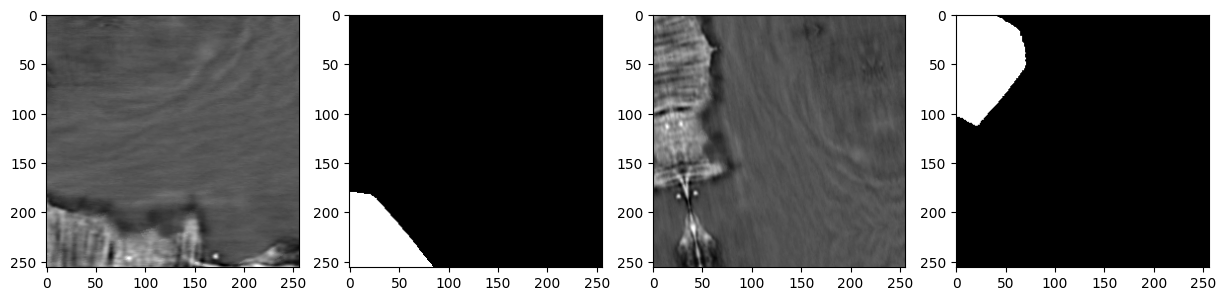

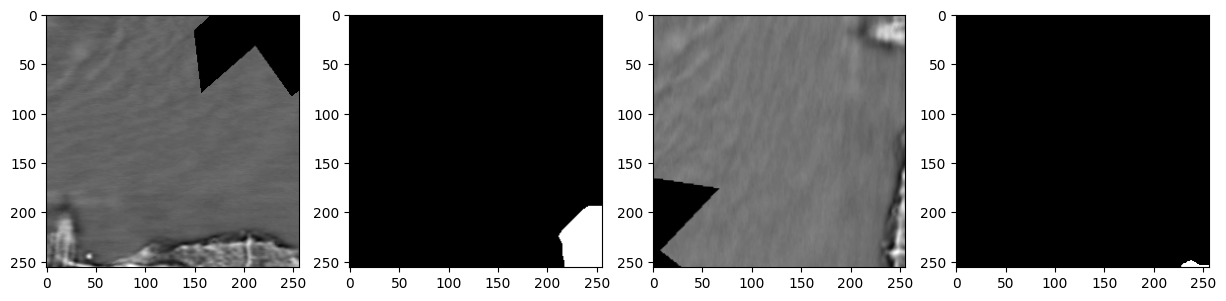

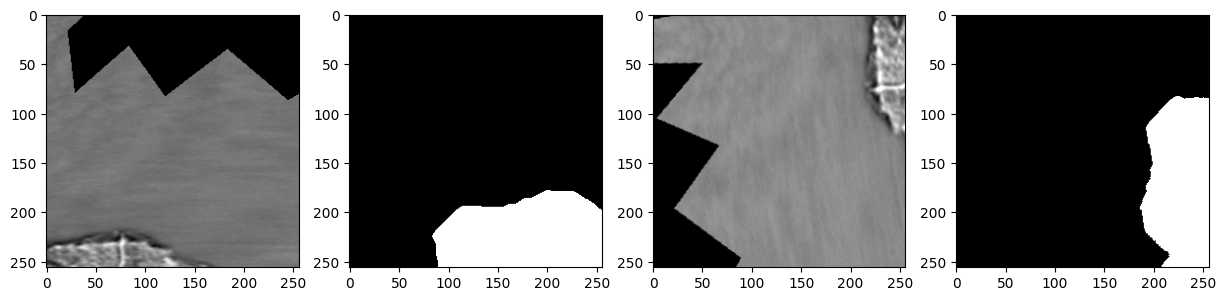

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
del plot_dataset
gc.collect()

51201

## model

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [26]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [27]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [28]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/690 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1241389002329742
th: 0.15, fbeta: 0.1241576815843031
th: 0.2, fbeta: 0.12533591305682135
th: 0.25, fbeta: 0.21513241123353086
th: 0.3, fbeta: 0.2575178924859136
th: 0.35, fbeta: 0.29999264101634737
th: 0.4, fbeta: 0.34195593622780834
th: 0.45, fbeta: 0.37590999519723606


best_th: 0.5, fbeta: 0.39432675079413365
Epoch 1 - avg_train_loss: 0.6080  avg_val_loss: 0.4161  time: 137s
Epoch 1 - avgScore: 0.3943
Epoch 1 - Save Best Score: 0.3943 Model
Epoch 1 - Save Best Loss: 0.4161 Model


th: 0.5, fbeta: 0.39432675079413365


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12413913013089099
th: 0.15, fbeta: 0.12478832003647142
th: 0.2, fbeta: 0.22444673829151138
th: 0.25, fbeta: 0.2744942576547182
th: 0.3, fbeta: 0.3114965262397185
th: 0.35, fbeta: 0.3358378323476427
th: 0.4, fbeta: 0.3572670468481503
th: 0.45, fbeta: 0.3766065963390636


best_th: 0.5, fbeta: 0.3959134622522865
Epoch 2 - avg_train_loss: 0.4147  avg_val_loss: 0.3856  time: 141s
Epoch 2 - avgScore: 0.3959
Epoch 2 - Save Best Score: 0.3959 Model
Epoch 2 - Save Best Loss: 0.3856 Model


th: 0.5, fbeta: 0.3959134622522865


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.31001382344516126
th: 0.15, fbeta: 0.35065293601093894
th: 0.2, fbeta: 0.38064272831889273
th: 0.25, fbeta: 0.40766339062519247
th: 0.3, fbeta: 0.4318826914128965
th: 0.35, fbeta: 0.45074460219736606
th: 0.4, fbeta: 0.464346945013904
th: 0.45, fbeta: 0.4734803160446105


best_th: 0.5, fbeta: 0.4765905034528684
Epoch 3 - avg_train_loss: 0.3016  avg_val_loss: 0.2514  time: 141s
Epoch 3 - avgScore: 0.4766
Epoch 3 - Save Best Score: 0.4766 Model
Epoch 3 - Save Best Loss: 0.2514 Model


th: 0.5, fbeta: 0.4765905034528684


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3211434615270299
th: 0.15, fbeta: 0.35098809130527003
th: 0.2, fbeta: 0.3729766282929172
th: 0.25, fbeta: 0.39199259560070404
th: 0.3, fbeta: 0.41176641129591046
th: 0.35, fbeta: 0.43019989338586945
th: 0.4, fbeta: 0.44822698320310145
th: 0.45, fbeta: 0.46346798685588264


best_th: 0.5, fbeta: 0.47726609611997245
Epoch 4 - avg_train_loss: 0.2506  avg_val_loss: 0.2526  time: 140s
Epoch 4 - avgScore: 0.4773
Epoch 4 - Save Best Score: 0.4773 Model
Epoch 4 - Save Best Loss: 0.2526 Model


th: 0.5, fbeta: 0.47726609611997245


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3740414821243956
th: 0.15, fbeta: 0.4174168001350264
th: 0.2, fbeta: 0.455740145955003
th: 0.25, fbeta: 0.49155242432599605
th: 0.3, fbeta: 0.5200483500957978
th: 0.35, fbeta: 0.5359587213996378
th: 0.4, fbeta: 0.5433680251832143
th: 0.45, fbeta: 0.5430257795503504


best_th: 0.4, fbeta: 0.5433680251832143
Epoch 5 - avg_train_loss: 0.2328  avg_val_loss: 0.2344  time: 141s
Epoch 5 - avgScore: 0.5434
Epoch 5 - Save Best Score: 0.5434 Model
Epoch 5 - Save Best Loss: 0.2344 Model


th: 0.5, fbeta: 0.5371586087148428


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3520846472770312
th: 0.15, fbeta: 0.3873730681170606
th: 0.2, fbeta: 0.4167581025046308
th: 0.25, fbeta: 0.44102352618890334
th: 0.3, fbeta: 0.461427145882949
th: 0.35, fbeta: 0.4805163147176162
th: 0.4, fbeta: 0.4970592677663469
th: 0.45, fbeta: 0.5095424201775642


best_th: 0.5, fbeta: 0.5194074733531973
Epoch 6 - avg_train_loss: 0.2180  avg_val_loss: 0.2497  time: 139s
Epoch 6 - avgScore: 0.5194


th: 0.5, fbeta: 0.5194074733531973


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3400755537361478
th: 0.15, fbeta: 0.37845237591340486
th: 0.2, fbeta: 0.41472379545057686
th: 0.25, fbeta: 0.44686451257896964
th: 0.3, fbeta: 0.4701493057561752
th: 0.35, fbeta: 0.488111938674847
th: 0.4, fbeta: 0.5042303538127342
th: 0.45, fbeta: 0.517636170758181


best_th: 0.5, fbeta: 0.5271791667432842
Epoch 7 - avg_train_loss: 0.2058  avg_val_loss: 0.2377  time: 140s
Epoch 7 - avgScore: 0.5272


th: 0.5, fbeta: 0.5271791667432842


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30933539179125186
th: 0.15, fbeta: 0.3393684522976565
th: 0.2, fbeta: 0.3698619978950241
th: 0.25, fbeta: 0.39709726385002064
th: 0.3, fbeta: 0.42895211086916274
th: 0.35, fbeta: 0.46013460579063586
th: 0.4, fbeta: 0.4833577260867945
th: 0.45, fbeta: 0.49604720578185657


best_th: 0.5, fbeta: 0.5018718849121765
Epoch 8 - avg_train_loss: 0.1910  avg_val_loss: 0.2457  time: 140s
Epoch 8 - avgScore: 0.5019


th: 0.5, fbeta: 0.5018718849121765


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38496135463962283
th: 0.15, fbeta: 0.4245063417518046
th: 0.2, fbeta: 0.45755849401918125
th: 0.25, fbeta: 0.4851857417116029
th: 0.3, fbeta: 0.5094319559196822
th: 0.35, fbeta: 0.5307017971795219
th: 0.4, fbeta: 0.5491974053231662
th: 0.45, fbeta: 0.5640551413077999


best_th: 0.5, fbeta: 0.5740616227409235
Epoch 9 - avg_train_loss: 0.1783  avg_val_loss: 0.2242  time: 140s
Epoch 9 - avgScore: 0.5741
Epoch 9 - Save Best Score: 0.5741 Model
Epoch 9 - Save Best Loss: 0.2242 Model


th: 0.5, fbeta: 0.5740616227409235


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40892113288897936
th: 0.15, fbeta: 0.4459598618239662
th: 0.2, fbeta: 0.4735518884866528
th: 0.25, fbeta: 0.49658920403275325
th: 0.3, fbeta: 0.5164172896413503
th: 0.35, fbeta: 0.532323714704648
th: 0.4, fbeta: 0.5456656839586738
th: 0.45, fbeta: 0.5538014241936249


best_th: 0.5, fbeta: 0.5556546883948016
Epoch 10 - avg_train_loss: 0.1661  avg_val_loss: 0.2455  time: 140s
Epoch 10 - avgScore: 0.5557


th: 0.5, fbeta: 0.5556546883948016


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4359183225115671
th: 0.15, fbeta: 0.4729733326700332
th: 0.2, fbeta: 0.502112019421832
th: 0.25, fbeta: 0.5244518806796182
th: 0.3, fbeta: 0.542685882662907
th: 0.35, fbeta: 0.5552217167376831
th: 0.4, fbeta: 0.5619989339310574
th: 0.45, fbeta: 0.5659610537807428


best_th: 0.45, fbeta: 0.5659610537807428
Epoch 11 - avg_train_loss: 0.1572  avg_val_loss: 0.2651  time: 140s
Epoch 11 - avgScore: 0.5660


th: 0.5, fbeta: 0.5608072922623434


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4077568313885417
th: 0.15, fbeta: 0.4368586132111832
th: 0.2, fbeta: 0.4605038800320202
th: 0.25, fbeta: 0.48108677126296273
th: 0.3, fbeta: 0.5001557209008266
th: 0.35, fbeta: 0.5167801121235815
th: 0.4, fbeta: 0.528966018011767
th: 0.45, fbeta: 0.5379184373716184


best_th: 0.5, fbeta: 0.5440797617019498
Epoch 12 - avg_train_loss: 0.1477  avg_val_loss: 0.2691  time: 140s
Epoch 12 - avgScore: 0.5441


th: 0.5, fbeta: 0.5440797617019498


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4411889970265237
th: 0.15, fbeta: 0.46826448300692713
th: 0.2, fbeta: 0.48941094910932775
th: 0.25, fbeta: 0.5068471514152706
th: 0.3, fbeta: 0.5221541442904402
th: 0.35, fbeta: 0.5312608945702928
th: 0.4, fbeta: 0.5376238093893868
th: 0.45, fbeta: 0.5398705289462603


best_th: 0.45, fbeta: 0.5398705289462603
Epoch 13 - avg_train_loss: 0.1366  avg_val_loss: 0.2990  time: 140s
Epoch 13 - avgScore: 0.5399


th: 0.5, fbeta: 0.5374486478306284


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4304039234405438
th: 0.15, fbeta: 0.46157054924756014
th: 0.2, fbeta: 0.4848187533585786
th: 0.25, fbeta: 0.498837347085628
th: 0.3, fbeta: 0.5066563446623505
th: 0.35, fbeta: 0.5130172433564856
th: 0.4, fbeta: 0.5134695331627811
th: 0.45, fbeta: 0.5115833631629746


best_th: 0.4, fbeta: 0.5134695331627811
Epoch 14 - avg_train_loss: 0.1299  avg_val_loss: 0.3030  time: 140s
Epoch 14 - avgScore: 0.5135


th: 0.5, fbeta: 0.5048241718160938


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4418672825080628
th: 0.15, fbeta: 0.47055241683133703
th: 0.2, fbeta: 0.49530040707315565
th: 0.25, fbeta: 0.512873061328168
th: 0.3, fbeta: 0.5256907472041307
th: 0.35, fbeta: 0.5343709908975793
th: 0.4, fbeta: 0.5387218352675853
th: 0.45, fbeta: 0.541259669138872


best_th: 0.45, fbeta: 0.541259669138872
Epoch 15 - avg_train_loss: 0.1228  avg_val_loss: 0.3107  time: 141s
Epoch 15 - avgScore: 0.5413


th: 0.5, fbeta: 0.5365166546651485


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3490762237108407
th: 0.15, fbeta: 0.3745765253020337
th: 0.2, fbeta: 0.3967459237873935
th: 0.25, fbeta: 0.42016708690819554
th: 0.3, fbeta: 0.4435616064987843
th: 0.35, fbeta: 0.46333645234033627
th: 0.4, fbeta: 0.47888034831732407
th: 0.45, fbeta: 0.4910956034736773


best_th: 0.5, fbeta: 0.5033679487891332
Epoch 16 - avg_train_loss: 0.1159  avg_val_loss: 0.2986  time: 141s
Epoch 16 - avgScore: 0.5034


th: 0.5, fbeta: 0.5033679487891332


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4327480741209177
th: 0.15, fbeta: 0.45505344050750535
th: 0.2, fbeta: 0.468555588644527
th: 0.25, fbeta: 0.4762686007750774
th: 0.3, fbeta: 0.4783312718503734
th: 0.35, fbeta: 0.4745395489801265
th: 0.4, fbeta: 0.4661139690524559
th: 0.45, fbeta: 0.4541558022642239


best_th: 0.3, fbeta: 0.4783312718503734
Epoch 17 - avg_train_loss: 0.1104  avg_val_loss: 0.3607  time: 141s
Epoch 17 - avgScore: 0.4783


th: 0.5, fbeta: 0.43652583980532034


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43660394768512245
th: 0.15, fbeta: 0.4637141112188555
th: 0.2, fbeta: 0.4832738380141904
th: 0.25, fbeta: 0.4990346370491221
th: 0.3, fbeta: 0.5126039872073833
th: 0.35, fbeta: 0.5239456998740136
th: 0.4, fbeta: 0.5335172242324508
th: 0.45, fbeta: 0.5402704033744785


best_th: 0.5, fbeta: 0.5451278324629075
Epoch 18 - avg_train_loss: 0.1031  avg_val_loss: 0.3087  time: 141s
Epoch 18 - avgScore: 0.5451


th: 0.5, fbeta: 0.5451278324629075


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4507218761905346
th: 0.15, fbeta: 0.47892532775797547
th: 0.2, fbeta: 0.5016289296989387
th: 0.25, fbeta: 0.5199706374052354
th: 0.3, fbeta: 0.5323850430526336
th: 0.35, fbeta: 0.5408393041260263
th: 0.4, fbeta: 0.5472144936071452
th: 0.45, fbeta: 0.5503030248919206


best_th: 0.45, fbeta: 0.5503030248919206
Epoch 19 - avg_train_loss: 0.0993  avg_val_loss: 0.3119  time: 141s
Epoch 19 - avgScore: 0.5503


th: 0.5, fbeta: 0.5492213208244681


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4081629541948719
th: 0.15, fbeta: 0.43519650000250765
th: 0.2, fbeta: 0.45535620067487204
th: 0.25, fbeta: 0.4714206465266566
th: 0.3, fbeta: 0.4841550780850828
th: 0.35, fbeta: 0.49186396799044585
th: 0.4, fbeta: 0.49786119927339156
th: 0.45, fbeta: 0.5005746465035598


best_th: 0.5, fbeta: 0.5006549515401181
Epoch 20 - avg_train_loss: 0.0945  avg_val_loss: 0.3466  time: 141s
Epoch 20 - avgScore: 0.5007


th: 0.5, fbeta: 0.5006549515401181


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4162569190658856
th: 0.15, fbeta: 0.4370353554641355
th: 0.2, fbeta: 0.4545385885275323
th: 0.25, fbeta: 0.46931521306455193
th: 0.3, fbeta: 0.480643448674621
th: 0.35, fbeta: 0.49002632638959087
th: 0.4, fbeta: 0.4998198247353739
th: 0.45, fbeta: 0.5085938063780262


best_th: 0.5, fbeta: 0.515518538013646
Epoch 21 - avg_train_loss: 0.0904  avg_val_loss: 0.3595  time: 142s
Epoch 21 - avgScore: 0.5155


th: 0.5, fbeta: 0.515518538013646


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4163427612288609
th: 0.15, fbeta: 0.4431884231083929
th: 0.2, fbeta: 0.46413583659068086
th: 0.25, fbeta: 0.48196330219084393
th: 0.3, fbeta: 0.4972163317474432
th: 0.35, fbeta: 0.5079098061441311
th: 0.4, fbeta: 0.5150939953685592
th: 0.45, fbeta: 0.5192067265849822


best_th: 0.5, fbeta: 0.5203184627988733
Epoch 22 - avg_train_loss: 0.0842  avg_val_loss: 0.3190  time: 142s
Epoch 22 - avgScore: 0.5203


th: 0.5, fbeta: 0.5203184627988733


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4300380722327194
th: 0.15, fbeta: 0.4502440062768775
th: 0.2, fbeta: 0.46719025902804107
th: 0.25, fbeta: 0.48263725827489684
th: 0.3, fbeta: 0.4939051627307877
th: 0.35, fbeta: 0.5005894512155454
th: 0.4, fbeta: 0.5045426927747755
th: 0.45, fbeta: 0.5055307266445191


best_th: 0.5, fbeta: 0.5055579175184663
Epoch 23 - avg_train_loss: 0.0817  avg_val_loss: 0.3772  time: 141s
Epoch 23 - avgScore: 0.5056


th: 0.5, fbeta: 0.5055579175184663


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42491241103582866
th: 0.15, fbeta: 0.4480221997664723
th: 0.2, fbeta: 0.46735126091707024
th: 0.25, fbeta: 0.481827850363516
th: 0.3, fbeta: 0.49354207926988203
th: 0.35, fbeta: 0.5021378113284656
th: 0.4, fbeta: 0.5083134235317905
th: 0.45, fbeta: 0.5127760500482291


best_th: 0.5, fbeta: 0.5172647164976409
Epoch 24 - avg_train_loss: 0.0775  avg_val_loss: 0.3585  time: 141s
Epoch 24 - avgScore: 0.5173


th: 0.5, fbeta: 0.5172647164976409


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42914424553021197
th: 0.15, fbeta: 0.45023025073247186
th: 0.2, fbeta: 0.46723612424687905
th: 0.25, fbeta: 0.4832222815559442
th: 0.3, fbeta: 0.4962786884480494
th: 0.35, fbeta: 0.5039871123972003
th: 0.4, fbeta: 0.5091914402786247
th: 0.45, fbeta: 0.5112630896996357


best_th: 0.45, fbeta: 0.5112630896996357
Epoch 25 - avg_train_loss: 0.0753  avg_val_loss: 0.3725  time: 141s
Epoch 25 - avgScore: 0.5113


th: 0.5, fbeta: 0.5110689352062601


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4453139577343309
th: 0.15, fbeta: 0.46605006890999856
th: 0.2, fbeta: 0.48222785632663745
th: 0.25, fbeta: 0.4962460551764925
th: 0.3, fbeta: 0.504616929464892
th: 0.35, fbeta: 0.5087910895960338
th: 0.4, fbeta: 0.5113887388538101
th: 0.45, fbeta: 0.5141524059213401


best_th: 0.5, fbeta: 0.5155531722764792
Epoch 26 - avg_train_loss: 0.0736  avg_val_loss: 0.3987  time: 141s
Epoch 26 - avgScore: 0.5156


th: 0.5, fbeta: 0.5155531722764792


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4330244915427297
th: 0.15, fbeta: 0.45800498528047756
th: 0.2, fbeta: 0.47744914805658684
th: 0.25, fbeta: 0.49331845691054804
th: 0.3, fbeta: 0.5062418512563116
th: 0.35, fbeta: 0.5138818371671657
th: 0.4, fbeta: 0.519610973810999
th: 0.45, fbeta: 0.5224773855413056


best_th: 0.5, fbeta: 0.5238795582241971
Epoch 27 - avg_train_loss: 0.0700  avg_val_loss: 0.3781  time: 141s
Epoch 27 - avgScore: 0.5239


th: 0.5, fbeta: 0.5238795582241971


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46174476869189146
th: 0.15, fbeta: 0.48394526343006516
th: 0.2, fbeta: 0.4999164085078466
th: 0.25, fbeta: 0.5119086251012018
th: 0.3, fbeta: 0.5192181063468018
th: 0.35, fbeta: 0.5236858348101316
th: 0.4, fbeta: 0.5261550606395411
th: 0.45, fbeta: 0.5273540495747892


best_th: 0.45, fbeta: 0.5273540495747892
Epoch 28 - avg_train_loss: 0.0699  avg_val_loss: 0.4050  time: 141s
Epoch 28 - avgScore: 0.5274


th: 0.5, fbeta: 0.5249347061907766


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4429916790320601
th: 0.15, fbeta: 0.46625326272901646
th: 0.2, fbeta: 0.48522523062386597
th: 0.25, fbeta: 0.50172820425145
th: 0.3, fbeta: 0.5125774461774371
th: 0.35, fbeta: 0.5203131651302458
th: 0.4, fbeta: 0.5258870556604414
th: 0.45, fbeta: 0.529636044507634


best_th: 0.5, fbeta: 0.5307014359664051
Epoch 29 - avg_train_loss: 0.0687  avg_val_loss: 0.3883  time: 141s
Epoch 29 - avgScore: 0.5307


th: 0.5, fbeta: 0.5307014359664051


  0%|          | 0/690 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44218463747947434
th: 0.15, fbeta: 0.46410587953353
th: 0.2, fbeta: 0.48011761232474587
th: 0.25, fbeta: 0.4951785545492733
th: 0.3, fbeta: 0.5048426491420573
th: 0.35, fbeta: 0.5099029189514298
th: 0.4, fbeta: 0.5133304087959177
th: 0.45, fbeta: 0.5158969725709299


best_th: 0.45, fbeta: 0.5158969725709299
Epoch 30 - avg_train_loss: 0.0674  avg_val_loss: 0.4054  time: 141s
Epoch 30 - avgScore: 0.5159


th: 0.5, fbeta: 0.5154075098276626


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.38496135463962283
th: 0.15, fbeta: 0.4245063417518046
th: 0.2, fbeta: 0.45755849401918125
th: 0.25, fbeta: 0.4851857417116029
th: 0.3, fbeta: 0.5094319559196822
th: 0.35, fbeta: 0.5307017971795219
th: 0.4, fbeta: 0.5491974053231662
th: 0.45, fbeta: 0.5640551413077999


best_th: 0.5, fbeta: 0.5740616227409235


th: 0.5, fbeta: 0.5740616227409235


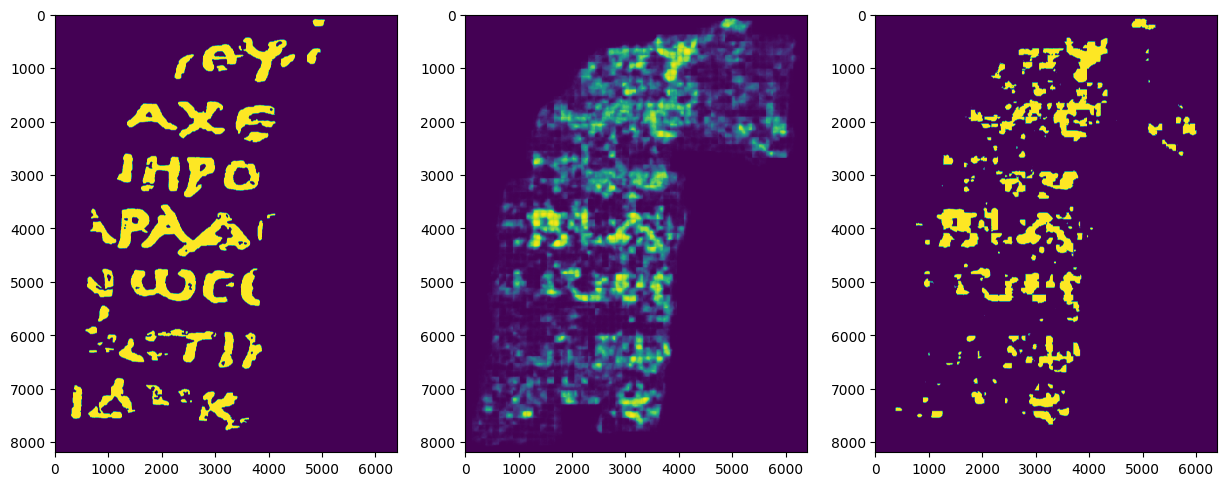

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([35148098.,  3883761.,  2285407.,  1659605.,  1275423.,  1108584.,
          954152.,   838833.,   750267.,   663180.,   608313.,   558144.,
          517701.,   450945.,   392459.,   351986.,   333839.,   299531.,
          234948.,   113624.]),
 array([6.07796046e-05, 4.98660551e-02, 9.96713305e-02, 1.49476606e-01,
        1.99281881e-01, 2.49087157e-01, 2.98892432e-01, 3.48697708e-01,
        3.98502983e-01, 4.48308259e-01, 4.98113534e-01, 5.47918810e-01,
        5.97724085e-01, 6.47529361e-01, 6.97334636e-01, 7.47139912e-01,
        7.96945187e-01, 8.46750462e-01, 8.96555738e-01, 9.46361013e-01,
        9.96166289e-01]),
 <BarContainer object of 20 artists>)

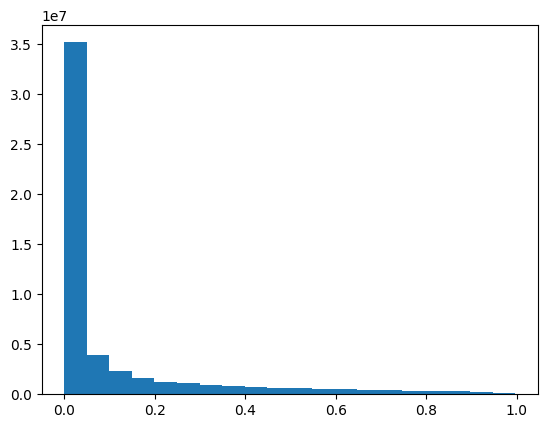

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000